## Playing around with `torch_dreams.lucid`

This simple module was heavily inspired from: [Feature Visualization: How neural networks build up their understanding of images](https://distill.pub/2017/feature-visualization/)

`torch_dreams.lucid` aims to be something like [tensorflow/lucid](https://github.com/tensorflow/lucid) but in PyTorch in order to facilitate research in neural network interpretability

**Note**: This is by no means a PyTorch equivalent of lucid. But rather it is a bunch of useful tools which have similar intent to that of lucid.

In this notebook, we test out `torch_dreams.lucid` while trying to visualize the features within the [VGG_19](https://arxiv.org/abs/1409.1556).

In [1]:

import cv2
import numpy as np
import matplotlib.pyplot as plt

from torch_dreams import utils
from torch_dreams.lucid import dreamer

import torchvision.models as models 

### First off, let's load up the model
After loading up the model, we make 2 more lists:
* `conv_layers` contains the names of all the feature extraction layers within the VGG19
* `linear_layers` contains the names of all the linear layers including the output layer

In [2]:

model = models.vgg19(pretrained = True)
model.eval()

# print(list(model.parameters()))

conv_layers = list(model.features.children())
linear_layers = list(model.classifier.children())

# print(layers[0].weight.data)


instead of optimizing the layer activation

we should optimize a custom function which returns the activation of a certain neuron 

need to make changes on torch_dreams_lucid 

### Preprocessing
`preprocess` should be a function which returns a tensor after applying the `torchvision.transforms` as per your wish.

I am planning to remove this preprocessing function fuss later on and make `torch_dreams` fully compatible with torch. 

In [3]:
preprocess = utils.preprocess_func
deprocess = None

### Initiating the `dreamer` and loading up a sample image

In [4]:


dreamer = dreamer(model, preprocess, deprocess)
image_sample = cv2.resize(cv2.imread("sample.jpg"), (1024,720))

# image_sample = np.random.rand(512,512,3).astype(np.float32)


In [5]:
dreamer.device

device(type='cuda')

### Deep-dreams w.r.t the output logits

We selected the last layer from `linear_layers` i.e `linear_layers[-1]`.

Setting `channel = 698` means we'll be trying to maximize the value of the 698th category from the imageNet dataset i.e "palace". 

`channel` refers to the index in the outermost dim. Note that for linear layers, setting `channel = n` would mean maximizing the `nth` output of the layer selected. 

Check out [this gist](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a) if you want to know all of the other classes in the ImageNet dataset.

In [22]:
layer_index = -1  ## last layer 
layer = linear_layers[layer_index]
channel = 698  ## 698th class of last layer     channel = None
print(layer)

Linear(in_features=4096, out_features=1000, bias=True)


100%|██████████| 5/5 [00:21<00:00,  4.34s/it]


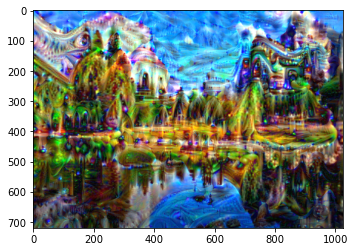

In [23]:
dreamed = dreamer.deep_dream(
                        image_np =image_sample, 
                        layer = layer, 
                        octave_scale = 1.5, 
                        num_octaves = 4, 
                        iterations = 40, 
                        lr = 0.31,
                        channel = channel
                        )

plt.imshow(cv2.cvtColor(dreamed, cv2.COLOR_BGR2RGB))
plt.show()

### Deep-dreams w.r.t individual channels of conv layers 

This time, we aim to optimize the 100th channel of the 14th feature extraction layer. 

**Note**: you can also set `channel = None` to maximize the activations of the whole layer.

In [24]:
layer_index = 14
layer = conv_layers[layer_index]
channel = 1
print(layer)

Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


100%|██████████| 8/8 [00:02<00:00,  3.98it/s]


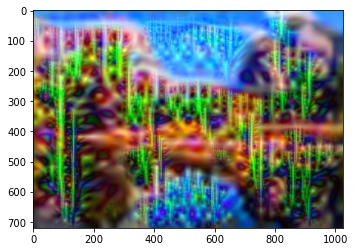

In [117]:
dreamed = dreamer.deep_dream(
                        image_np =image_sample, 
                        layer = layer, 
                        octave_scale = 1.5, 
                        num_octaves = 7, 
                        iterations = 5, 
                        lr = 0.08,
                        channel = channel
                        )

plt.imshow(cv2.cvtColor(dreamed, cv2.COLOR_BGR2RGB))
plt.show()

### Deep-dreams w.r.t conv layers 

We try to maximize the activations 14th feature extraction layer as a whole

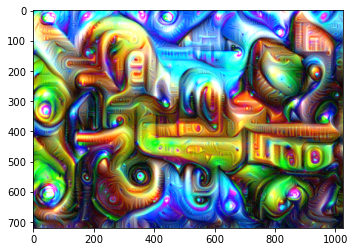

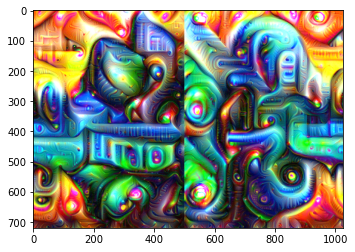

In [27]:
# layer_index = 14
# layer = conv_layers[layer_index]
# channel = None  ### set to none to maximize activations for the layer as a whole 
# # print(layer)

# dreamed = dreamer.deep_dream(
#                         image_np =image_sample, 
#                         layer = layer, 
#                         octave_scale = 1.5, 
#                         num_octaves = 7, 
#                         iterations = 5, 
#                         lr = 0.08,
#                         channel = channel
#                         )

plt.imshow(cv2.cvtColor(dreamed, cv2.COLOR_BGR2RGB))
plt.show()



## A deeper dive 

The `custom_func` can be used for more specfic optimization based feature extractions. You can basically apply any custom function to the layer output and use it to optimize the image. 

As seen below, we wrote a custom function `my_custom_func` that selects the first channel of the layer output for optimization. 

Optimizing the image w.r.t a single neuron unit from one of the channels could be as easy as:

```python

def custom_func(layer_output):    
    op = layer_output[10][0][0].norm() ## the very first unit
    return op

```


0.4530179 0.23233385


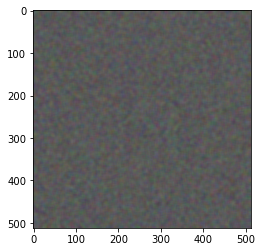

In [109]:
image_sample = cv2.blur(np.random.rand(512,512,3).astype(np.float32)*0.7, (9,9))
print(image_sample.max(), image_sample.min())
plt.imshow(image_sample)
plt.show()

In [110]:

layer_index = 23
layer = conv_layers[layer_index]
channel = None
print(layer)

Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


100%|██████████| 5/5 [00:01<00:00,  2.75it/s]


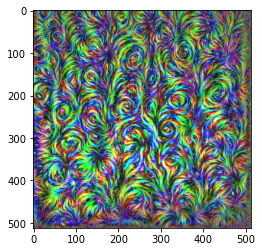

In [111]:
def custom_func(layer_output):
#     print(layer_output.size())
    
    op = layer_output[10].norm()
    return op

dreamed = dreamer.deep_dream(
                        image_np =image_sample, 
                        layer = layer, 
                        octave_scale = 1.5, 
                        num_octaves = 4, 
                        iterations = 10, 
                        lr = 0.25,
                        channel = None,
                        custom_func = custom_func
    
                        )
plt.imshow(cv2.cvtColor(dreamed, cv2.COLOR_BGR2RGB))
plt.show()

# d2 =  np.roll(dreamed, 200, axis=0)
# plt.imshow(d2)

In [112]:
all_vis = []

layer_index = 14
layer = conv_layers[layer_index]
channel = None
print(layer)


for i in range(25):
    def custom_func(layer_output):
    #     print(layer_output.size())

        op = layer_output[i].norm()
        return op

    vis = dreamer.deep_dream(
                            image_np =image_sample, 
                                layer = layer, 
                                octave_scale = 1.3, 
                                num_octaves = 9, 
                                iterations = 3, 
                                lr = 0.155,
                                channel = None,
                                custom_func = custom_func
                                )
    all_vis.append(vis)

 30%|███       | 3/10 [00:00<00:00, 29.15it/s]

Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


100%|██████████| 10/10 [00:00<00:00, 13.89it/s]


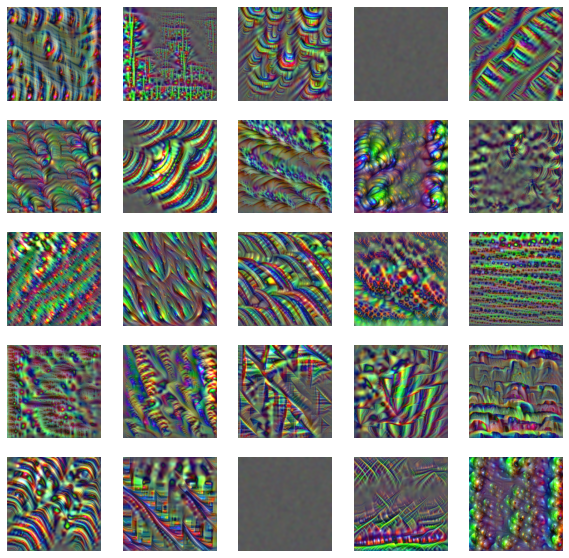

In [113]:
fig, ax = plt.subplots(nrows=5, ncols=5, figsize = (10,10))

for i in range(len(all_vis)):
    ax.flat[i].imshow(all_vis[i])
    ax.flat[i].axis("off")

In [38]:
!mkdir output

0.69999987 9.0666055e-07


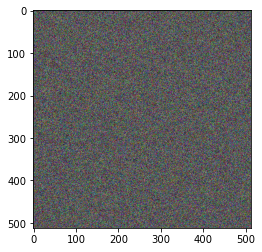

In [116]:
image_sample = np.random.rand(512,512,3).astype(np.float32)*0.7
print(image_sample.max(), image_sample.min())
plt.imshow(image_sample)
plt.show()

In [ ]:
layer_index = 14
layer = conv_layers[layer_index]
channel = None
print(layer)

nrows = 1
ncols = 1

all_vis = []


alphas = np.linspace(0,1,30)
channels = np.linspace(0, 100,7)
channels

for c in range(len(channels)-1):
    

    for alpha in alphas:

        def custom_func(layer_output):
    #         print(layer_output.size())
    #         print(alpa,1-alpha)

            op = layer_output[c+1].norm()*alpha + layer_output[c].norm()*(1-alpha)

            return op

        vis = dreamer.deep_dream(
                                image_np =image_sample, 
                                layer = layer, 
                                octave_scale = 1.2, 
                                num_octaves = 9, 
                                iterations = 3, 
                                lr = 0.155,
                                channel = None,
                                custom_func = custom_func
                                )
        all_vis.append(vis)

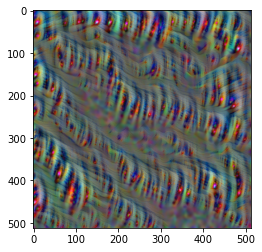

In [119]:
plt.imshow(all_vis[0])

In [122]:
from torch_dreams.utils import write_video_from_image_list

write_video_from_image_list(
    save_name = "deep_dive.mp4", 
    all_images_np = np.array(all_vis), 
    framerate = 40, 
    size = (512,512)
)